In [1]:
import os
os.environ['HF_HOME'] = '/data1/malto/cache'

In [2]:
from transformers import Trainer
import torch.nn as nn
import torch

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        p_hall = inputs.pop("p(Hallucination)")
        cond_weights = inputs.pop("C-W")
        cond_weights = torch.where(cond_weights > 0.5, 1.1, 0.1)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")[:, 0]
        loss_fn = nn.BCEWithLogitsLoss(reduction='none')
        loss = cond_weights * loss_fn(logits, p_hall)
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

    """def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys):
        phall = inputs.pop("p(Hallucination)")
        cw = inputs.pop("C-W")
        loss, logits, labels = super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)
        inputs['p(Hallucination)'] = phall
        inputs['C-W'] = cw
        loss = self.compute_loss(model, inputs)
        return loss, logits, labels"""

In [3]:
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from pathlib import Path
import scipy

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true"

BATCH_SIZE = 48
NUM_EPOCHS = 1
BASE_DIR = Path("/data1/malto/shroom/")

FREEZE = True
FROZEN_LAYERS = 15

#checkpoint = "microsoft/deberta-xlarge-mnli"
checkpoint = "microsoft/deberta-large-mnli"
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
def preprocess_function(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'] if examples['ref'] != 'src' else examples['src'], truncation=True, max_length=80)
    model_inputs["labels"] = [1 if t == "Hallucination" else 0 for t in examples['labels']]
    return model_inputs

def compute_metrics(eval_pred):
    #print(eval_pred)
    accuracy = evaluate.load("accuracy")
    predictions, labels = eval_pred
    #print(predictions, labels)
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "Not Hallucination", 1: "Hallucination"}
label2id = {"Not Hallucination": 0, "Hallucination": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

/data1/malto/fborra/venv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

In [5]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=2048, bias=True),
    nn.Sigmoid(),
    nn.Linear(in_features=2048, out_features=2, bias=True)
)

In [6]:
if FREEZE == True and checkpoint.startswith("microsoft"):
    print("freezing...")
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
    for param in model.deberta.encoder.layer[:FROZEN_LAYERS].parameters():
        param.requires_grad = False

freezing...


In [7]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
# dataset manipulation
ds_mt = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_MT_SOLAR.model-agnostic.json")])
ds_dm = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_DM_SOLAR.model-agnostic.json")])
ds_pg = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_PG_SOLAR.model-agnostic.json")])
ds_val = load_dataset("json", data_files=[str(BASE_DIR / f"val.model-agnostic.json")])['train'].train_test_split(test_size=0.1)

ds_mt = ds_mt.remove_columns([el for el in ds_mt['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=0.4)
ds_dm = ds_dm.remove_columns([el for el in ds_dm['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=0.4)
ds_pg = ds_pg.remove_columns([el for el in ds_pg['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=0.4)

ds = concatenate_datasets([ds_mt['train'], ds_dm['train'], ds_pg['train'], ds_val['train']])
ds = ds.shuffle(seed=42)
ds = DatasetDict({
    'train' : ds,
    'test' : ds_val['test'],
})
ds = ds.map(preprocess_function)
ds = ds.remove_columns(['hyp', 'src', 'task', 'ref', 'tgt', 'model', 'labels', 'label'])

ds

Map:   0%|          | 0/18449 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['C-W', 'p(Hallucination)', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18449
    })
    test: Dataset({
        features: ['p(Hallucination)', 'C-W', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [8]:
training_args = TrainingArguments(
    output_dir="/data1/malto/shroom/checkpoint/local_model",
    learning_rate=1e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_steps=1,
    report_to="none",
    remove_unused_columns=False,
)

trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        #compute_metrics=compute_metrics,
    )

trainer.label_names = []
trainer.can_return_loss = True

array([[<Axes: title={'center': '0'}>]], dtype=object)

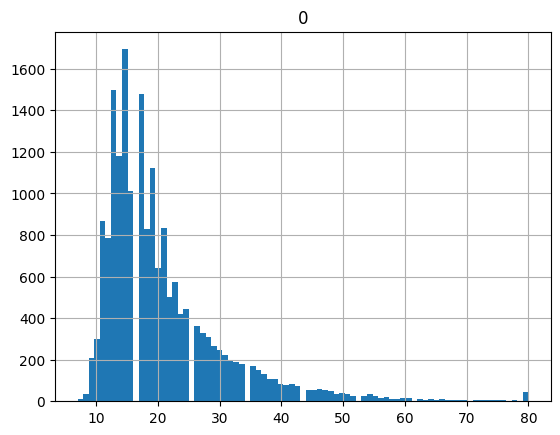

In [9]:
import pandas as pd

df = pd.DataFrame([len(el) for el in ds['train']['input_ids']])
df.hist(bins=81)

In [10]:
trainer.evaluate()

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7590070962905884,
 'eval_runtime': 0.5791,
 'eval_samples_per_second': 86.342,
 'eval_steps_per_second': 3.454}

In [13]:
def get_accuracy():
    predictions, _, _ = trainer.predict(ds["test"])

    #predictions = scipy.special.softmax(predictions, axis=-1)
    #predictions = np.argmax(predictions, axis=-1)
    predictions = scipy.special.expit(predictions[:, 0])
    predictions = np.where(predictions > 0.5, 0, 1)

    references = np.where(np.array(ds['test']['p(Hallucination)']) > 0.5, 0, 1)

    accuracy = (predictions == references).sum() / predictions.shape[0]
    return accuracy

get_accuracy()

0.8

In [12]:
from IPython.display import clear_output

accs = []
for i in range(3):
    clear_output(wait=True)
    print(i)
    print(accs)
    trainer.train()
    accs.append(get_accuracy())
clear_output(wait=True)
print(accs)

1
[0.8]


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Submission Generation

In [61]:
ds_test = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])
ds_test

DatasetDict({
    train: Dataset({
        features: ['tgt', 'task', 'src', 'id', 'hyp'],
        num_rows: 1500
    })
})

In [62]:
def preprocess_function_test(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'], truncation=True, max_length=80)
    return model_inputs
def add_columns(examples):
    return {'p(Hallucination)' : 0.01, 'C-W': 1.01}

ds_test = ds_test.map(preprocess_function_test).remove_columns(['tgt', 'task', 'src', 'id', 'hyp']).map(add_columns, batched=False)

In [63]:
import scipy
predictions, _, _ = trainer.predict(ds_test["train"])

probabilities = scipy.special.expit(predictions[:, 0])
predictions = np.where(probabilities > 0.5, "Hallucination", "Not Hallucination")

In [64]:
ds_test_new = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])

global count
count = 0
def add_predictions(examples):
    global count
    prob = probabilities[count]
    pred = predictions[count]
    count += 1
    return {'p(Hallucination)' : prob, 'label' : pred}
ds_test_new = ds_test_new.map(add_predictions).remove_columns(['tgt', 'task', 'src', 'hyp'])

In [65]:
ds_test_new['train'].to_json(str(BASE_DIR / "submission.json"))

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

105669

In [69]:
import json
l = [el for el in ds_test_new['train']]
with open(BASE_DIR / "submission.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(l))